From Table 10 of https://www.folkhalsomyndigheten.se/publicerat-material/publikationsarkiv/i/influenza-in-sweden/?pub=63511

In [1]:
import pandas as pd
df = pd.read_html("static-data/sweden-flu-age.html")[0]
df.columns = ["stat", "0-40", "40-64", "65-69", "70-74", "75-79", "80-84", "85-89", "90-94", "95-100", "total"]
df = df.set_index("stat")
df.index = ["total_cases", "cases per 100k", "total deaths", "deaths per 100k", "deaths among cases (%)", "none"]
df = df.drop("none")
df = df.T
df = df.drop("total")
df.index.name = "age range"
df = df.reset_index()
df["min_age"] = df["age range"].apply(lambda x: int(x.split("-")[0]))
df["max_age"] = df["age range"].apply(lambda x: int(x.split("-")[1]))

for col in ["cases per 100k", "deaths per 100k"]:
    df[col] = df[col].astype("float")

df["case_rate"] = df["cases per 100k"] / 100e3
df["death_rate"] = df["deaths per 100k"] / 100e3

cols = ["min_age", "max_age", "case_rate", "death_rate"]
flu = df[cols].copy()
flu["virus"] = "influenza"
flu.sample(n=4)

,min_age,max_age,case_rate,death_rate,virus
1,40,64,0.00101,0.000020,influenza
6,85,89,0.00593,0.000490,influenza
5,80,84,0.00428,0.000370,influenza
0,0,40,0.00082,0.000002,influenza


In [2]:
swe_ages = pd.read_csv("static-data/Sweden-2017.csv")
assert swe_ages.columns.tolist() == ["Age", "M", "F"]
swe_ages.columns = ["age", "m", "f"]
swe_ages = swe_ages.set_index("age").sum(axis=1)
swe_ages = swe_ages.reset_index()
swe_ages.loc[swe_ages["age"] == "100+", "age"] = "100-109"
swe_ages.columns = ["age", "population"]
swe_ages["min_age"] = swe_ages["age"].apply(lambda x: int(x.split("-")[0]))
swe_ages["max_age"] = swe_ages["age"].apply(lambda x: int(x.split("-")[1]))
# swe_ages.head()

In [3]:
def _get_ages(row, age_dist=None, catch=True):
    idx = (row.min_age <= age_dist.min_age) & (age_dist.max_age <= row.max_age)
    if catch:
        assert idx.sum() == 2
    return age_dist.loc[idx, "population"].sum()

`Sweden-2017.csv` form https://www.populationpyramid.net/sweden/2017/

In [4]:
data = {
    "cases": [494, 3276, 11592, 12152, 13300, 14399, 8281, 5835, 6521, 3526],
    "deaths": [1, 0, 8, 16, 45, 159, 389, 1229, 2367, 1486],
    "icu": [8, 15, 91, 116, 281, 638, 756, 494, 102, 3],
    "age range": ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99"],
}
sweden = pd.DataFrame(data)


sweden["min_age"] = sweden["age range"].apply(lambda x: int(x.split("-")[0]))
sweden["max_age"] = sweden["age range"].apply(lambda x: int(x.split("-")[1]))

sweden["population"] = sweden[["min_age", "max_age"]].apply(_get_ages, age_dist=swe_ages, axis=1)
sweden = sweden.drop(columns=["age range"])

sweden["case_rate"] = sweden["cases"] / sweden["population"]
sweden["death_rate"] = sweden["deaths"] / sweden["population"]

cols = ["min_age", "max_age", "case_rate", "death_rate"]
covid = sweden[cols].copy()
covid["virus"] = "COVID"
covid.sample(n=4)

,min_age,max_age,case_rate,death_rate,virus
5,50,59,0.011590,0.000128,COVID
8,80,89,0.016138,0.005858,COVID
9,90,99,0.033554,0.014141,COVID
2,20,29,0.008561,0.000006,COVID


In [5]:
df = pd.concat((flu, covid))

df = df.melt(id_vars=["case_rate", "death_rate", "virus"], value_name="age").drop(columns="variable")
df.sample(n=4)

,case_rate,death_rate,virus,age
9,0.000418,8.468447e-07,COVID,0
8,0.006440,1.450000e-03,influenza,95
5,0.004280,3.700000e-04,influenza,80
33,0.011590,1.279840e-04,COVID,59


Text(0.5, 1.0, 'Swedish COVID and flu mortality rate')

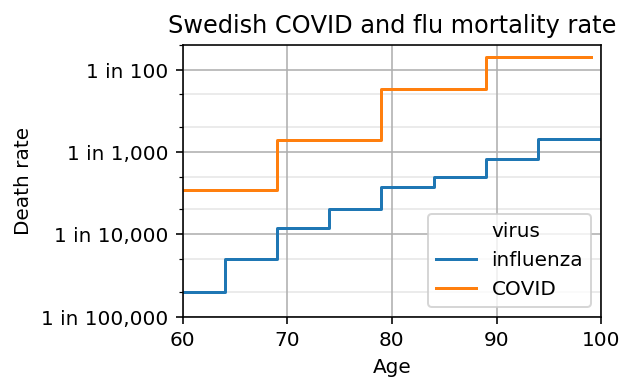

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df["deaths per 100k"] = df["death_rate"] * 100e3

w = 2.5
fig, ax = plt.subplots(figsize=(1.5 * w, w))
ax = sns.lineplot(
    x="age",
    y="death_rate",
    hue="virus",
    data=df,
    drawstyle="steps",
)
ax.set_yscale("log")
ax.set_xlim(60, 100)
ax.set_ylim(1e-5, 2e-2)
yticks = [[1 * 10**i, 2* 10**i, 5* 10**i] for i in range(-6, 6)]
yticks = [[1 * 10**i] for i in range(-6, 6)]
ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))
yticks = [[2 * 10**i, 5* 10**i] for i in range(-6, 6)]
ax.yaxis.set_minor_locator(plt.FixedLocator(sum(yticks, [])))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"1 in {int(np.round(1 / x)):,}"))
ax.grid(alpha=1.0)
ax.grid(alpha=0.3, which="minor", axis="y")
ax.set_ylabel("Death rate")
ax.set_xlabel("Age")
ax.set_title("Swedish COVID and flu mortality rate")

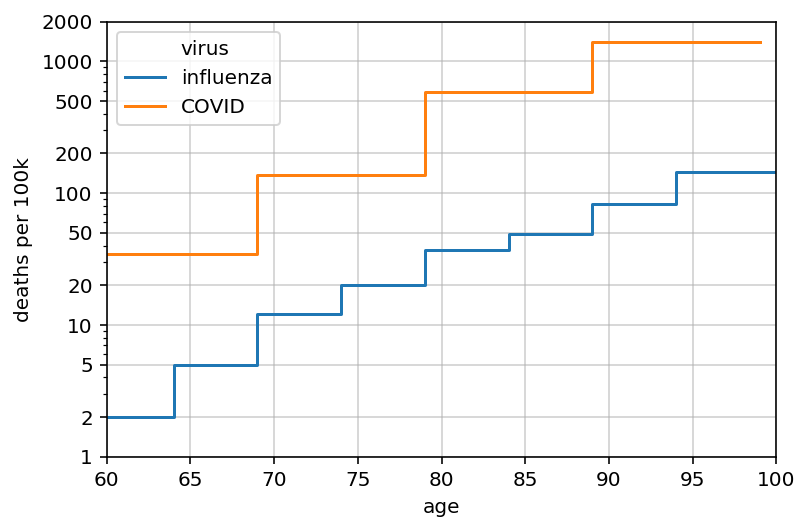

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df["deaths per 100k"] = df["death_rate"] * 100e3
ax = sns.lineplot(
    x="age",
    y="deaths per 100k",
    hue="virus",
    data=df,
    drawstyle="steps",
)
ax.set_yscale("log")
ax.set_xlim(60, 100)
ax.set_ylim(1, 2000)
ax.grid(alpha=0.6)
yticks = [[1 * 10**i, 2* 10**i, 5* 10**i] for i in range(-6, 6)]
ax.yaxis.set_major_locator(plt.FixedLocator(sum(yticks, [])))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))